Este projeto o trabalho de fim de curso do aluno Igor Peterossi Lopes (RA:174929) para o curso de engenharia elétrica da Unicamp, feito no 2 semestre de 2022.

Este trabalho pretende resolver um problema de classificação binária através de duas estratégias distintas: utilizando um classificador implementado com regressão logística e utilizando um classificador feito com uma rede neural e através dos resultados obtidos comparar os dois métodos de resolução do problema.

O problema que esta sendo analisado é o da classificação de websites em sites de phishing e sites seguros (que não são de phishing), os dados para essa classificação fazem parte do acervo de machine learning da University of California, School of Information and Computer Science, disponível no seguinte link: https://archive.ics.uci.edu/ml/datasets/phishing+websites


Como primeira etapa, obtemos os dados que serão estudados e depois passamos a fazer pequenas adaptações nestes a fim de viabilizar a sua utilização pelos modelos que serão desenvolvidos

In [76]:
from sklearn.datasets import fetch_openml

X_data, y_data = fetch_openml(data_id=4534, return_X_y=True)
X_data = X_data.astype("int64")
y_data = y_data.astype("int64")

def map_output(value):
    if value == -1:
        return 0
    return value

y_data = y_data.apply(map_output)

In [77]:
# y_data = y_data[:1000]
# X_data = X_data[:1000]
# X_data= X_data.loc[:, 'port':'SFH']

Agora realizamos algumas observações em cima dos dados para que possamos compreender melhor as suas características

In [78]:
X_data

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,1,-1,-1,-1,-1,1,1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,1,-1,-1,0,-1,1,1,1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,1,-1,1,-1,1,0,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,1,-1,-1,1,-1,1,-1,1
4,1,0,-1,1,1,-1,1,1,-1,1,...,1,-1,1,-1,-1,0,-1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11050,1,-1,1,-1,1,1,1,1,-1,-1,...,-1,-1,-1,1,1,-1,-1,1,1,1
11051,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,1,-1,1,1,1,1,1,1,-1,1
11052,1,-1,1,1,1,-1,1,-1,-1,1,...,1,1,1,1,1,1,-1,1,0,1
11053,-1,-1,1,1,1,-1,-1,-1,1,-1,...,1,-1,1,1,1,1,-1,1,1,1


In [79]:
y_data

0        0
1        0
2        0
3        0
4        1
        ..
11050    1
11051    0
11052    0
11053    0
11054    0
Name: Result, Length: 11055, dtype: int64

Primeiro, criamos o modelo de regressão logística. Usaremos a biblioteca scikit-learn para auxiliar no desenvolvimento do modelo, bem como na separação dos nossos dados em partes para treinamento e para validação posterior

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

Com o nosso modelo de regressão treinado, vamos agora identificar a sua performance, determinando a sua acurácia e também plotando uma matriz de confusão

In [81]:
y_pred = logreg.predict(X_test)
print('Acurácia do classificador de regressão logística no dataset de teste: {:.3f}'.format(logreg.score(X_test, y_test)))

Acurácia do classificador de regressão logística no dataset de teste: 0.923


In [82]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      1498
           1       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



In [83]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[1341  157]
 [  99 1720]]


Agora trabalharemos com o nosso modelo de deep learning. Implementamos uma rede neural de duas camadas, sendo uma camada interna com um nó para cada feature do dataset (30 nós ao todo), com uma função de ativação ReLu e uma camada externa que consolida o resultado anterior utilizando uma função sigmoide.
O modelo é montado para minimizar a função "binary cross entropy", usualmente utilizada para resolução de problemas de classificação binária, buscando otimizar a acurácia do classificador. O modelo

In [84]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(30, activation='relu', input_shape=(X_data.shape[1],)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 30)                930       
                                                                 
 dense_13 (Dense)            (None, 1)                 31        
                                                                 
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


Agora treinamos a nossa rede neural utilizando a mesma separação do dataset utilizada para o modelo de regressão logística, em batches de 100 e em 10 epochs. Depois avaliamos a sua perfomance, computando a acurácia final do modelo, a sua progressão após cada passo do treinamento e também a matriz de confusão

In [85]:
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=100, verbose=False)
deep_learning_loss, deep_learning_acc = model.evaluate(X_test,  y_test, verbose=2)
print('Acurácia da rede neural no dataset de teste: {:.3f}'.format(deep_learning_acc))

104/104 - 0s - loss: 0.1807 - accuracy: 0.9304 - 161ms/epoch - 2ms/step
Acurácia da rede neural no dataset de teste: 0.930


[]

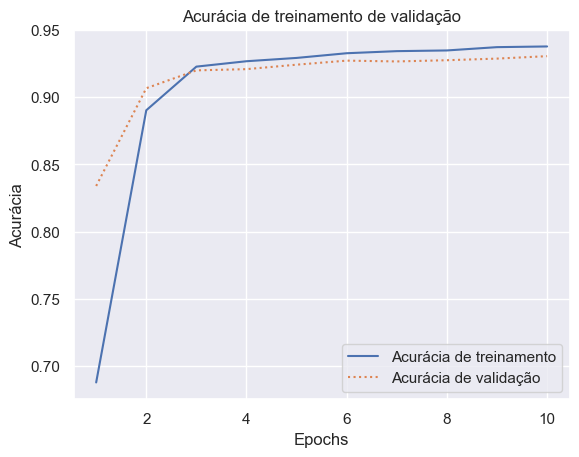

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Acurácia de treinamento')
plt.plot(epochs, val, ':', label='Acurácia de validação')
plt.title('Acurácia de treinamento de validação')
plt.xlabel('Epochs')
plt.ylabel('Acurácia')
plt.legend(loc='lower right')
plt.plot()